In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from diff_exp.scripts.faiss_find_closest import main as faiss_run, default_args as get_faiss_args
from diff_exp.scripts.compute_embeddings import get_image_embeddings, default_args as get_embedding_args, load_model_and_processor, ProcessorDataset, DataLoader, mkdirs4file
from diff_exp.data.npz_dataset import Dataset as NPZDataset
from omegaconf import OmegaConf
import torch as th
th.set_grad_enabled(False)
import numpy as np
import yaml
from diff_exp.utils import TransformDataset
from diff_exp.transforms_utils import get_transform
from tqdm import tqdm
from einops import rearrange



In [3]:
def compute_embeddings(args, dataset):
    model, processor = load_model_and_processor(args.model_name)
    #data = NPZDataset([args.input_npz])
    dataset = ProcessorDataset(dataset, processor)
    
    loader = DataLoader(dataset, batch_size=args.batch_size, num_workers=args.num_workers, pin_memory=True)
    model = model.to(args.device)
    model.eval()
    
    all_embeddings = get_image_embeddings(args, model, processor, loader)
    mkdirs4file(args.output_npz)
    np.savez(args.output_npz, all_embeddings)
    print(f"Saved {len(all_embeddings)} embeddings to {args.output_npz}.")


In [4]:
def dataset_to_npz(dataset):
    all_x = []
    loader = DataLoader(dataset, batch_size=64, num_workers=12)
    for x, y in tqdm(loader):
        x = x * 255
        x = x.byte()
        x = x.numpy()
        all_x.append(x)
    all_x = np.concatenate(all_x)
    all_x = rearrange(all_x, "b c h w -> b h w c")
    return all_x

In [5]:
generated_samples_npz = "/home/anon/samples/smile_size_ablation/5k/guid_30/samples_10000x64x64x3.npz"
generated_samples_embed_npz = "embeddings/smile_mild/5k_guid_30.npz"


celeba_samples_npz = "npz/celeba_train_5k.npz"
celeba_samples_embed_npz = "embeddings/smile_mild/train_5k.npz"


faiss_save_dir = "5k_smile_plots"
filter_path = "/home/anon/Documents/DiffusionExtrapolation-code/diff_exp/data/celeba_smile_train_size_ablation/5k.txt"



### Compute embeddings of generated samples

In [6]:
# Prepare dataset
embed_args = get_embedding_args()
embed_args = OmegaConf.create(embed_args)
embed_args.batch_size = 64
embed_args.device = "cuda:1"
embed_args.input_npz = generated_samples_npz
embed_args.output_npz = generated_samples_embed_npz
embed_args.num_workers = 10

print(OmegaConf.to_yaml(embed_args))

# Embed dataaset
dataset = NPZDataset(embed_args.input_npz)
compute_embeddings(embed_args, dataset)

model_name: openai/clip-vit-base-patch32
batch_size: 64
device: cuda:1
input_npz: /home/anon/samples/smile_size_ablation/5k/guid_30/samples_10000x64x64x3.npz
output_npz: embeddings/smile_mild/5k_guid_30.npz
num_workers: 10



Embedding data...: 100%|████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.88it/s]

Saved 10000 embeddings to embeddings/smile_mild/5k_guid_30.npz.


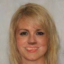

In [7]:
from PIL import Image
idx = 17
img = dataset[idx][0]
Image.fromarray(img)

### Compute embeddings of training data

In [8]:
from diff_exp.data.attribute_celeba_dataset import default_args as get_celeba_args, Dataset as CelebA

# Prepare dataset
celeba_args = get_celeba_args()
celeba_args = OmegaConf.create(celeba_args)
celeba_args.data_dir = "../../data"
celeba_args.filter_path = filter_path

celeba_dataset = CelebA(**celeba_args)
print("Dataset args:")
print(OmegaConf.to_yaml(celeba_args))
print("Dataset len:", len(celeba_dataset))
print("-----")

# Embed dataset
embed_args = get_embedding_args()
embed_args = OmegaConf.create(embed_args)
embed_args.batch_size = 64
embed_args.device = "cuda:1"
embed_args.output_npz = celeba_samples_embed_npz
embed_args.num_workers = 10
print("Embedding args")
print(OmegaConf.to_yaml(embed_args))
print("-----")

compute_embeddings(embed_args, celeba_dataset)

# Make CelebA into npz (for faiss)
transform_str = """
- - to_tensor
- - center_crop
  - size: 178
- - resize
  - size: 64
""".strip()

transform = yaml.safe_load(transform_str)
transform = OmegaConf.create(transform)
transform = get_transform(transform)

transform = yaml.safe_load(transform_str)
transform = get_transform(transform)
celeba_transformed = TransformDataset(celeba_dataset, transform)
celeba_npz = dataset_to_npz(celeba_transformed)

mkdirs4file(celeba_samples_npz)
np.savez(celeba_samples_npz, celeba_npz)

Dataset args:
target_attr: Smiling
data_dir: ../../data
split: train
filter_path: /home/anon/Documents/DiffusionExtrapolation-code/diff_exp/data/celeba_smile_train_size_ablation/5k.txt

Dataset len: 5000
-----
Embedding args
model_name: openai/clip-vit-base-patch32
batch_size: 64
device: cuda:1
input_npz: /home/anon/samples/uncond_celeb_all_ddpm/samples_10000x64x64x3.npz
output_npz: embeddings/smile_mild/train_5k.npz
num_workers: 10

-----


Embedding data...: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:06<00:00, 12.50it/s]


Saved 5000 embeddings to embeddings/smile_mild/train_5k.npz.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 57.27it/s]


### Faiss + plots

In [9]:
faiss_args = get_faiss_args()
faiss_args = OmegaConf.create(faiss_args)
# Source: neighbouring images
faiss_args.source_images = celeba_samples_npz
faiss_args.source_embeddings = celeba_samples_embed_npz
# Target: reference image
faiss_args.target_images = generated_samples_npz
faiss_args.target_embeddings = generated_samples_embed_npz
faiss_args.save_dir = faiss_save_dir
faiss_args.use_cosine_sim = True
faiss_args.top_k = 8
faiss_args.n_images = 5
faiss_args.suptitle = ""
print(OmegaConf.to_yaml(faiss_args))


source_images: npz/celeba_train_5k.npz
source_embeddings: embeddings/smile_mild/train_5k.npz
target_images: /home/anon/samples/smile_size_ablation/5k/guid_30/samples_10000x64x64x3.npz
target_embeddings: embeddings/smile_mild/5k_guid_30.npz
save_dir: 5k_smile_plots
use_cosine_sim: true
top_k: 8
n_images: 5
dist_idx: 0
suptitle: ''



In [10]:
faiss_run(faiss_args)

Compute top 8 neighbours in 0.28 seconds.


Generating neighbour images: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11990.58it/s]
